# 4. Scrape and Plot 2015 Baseball Standings (plotly)

### Begin by importing our modules

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets
from IPython.display import display
from collections import OrderedDict
from datetime import datetime as dt

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

### Now load the master data we'll use

In [45]:
dfMaster = pd.read_csv('../data/dayByDayStandings2015.csv')
dfMaster.fillna(0, inplace=True)
dfMaster['date'] = pd.to_datetime(dfMaster['date'])
dfMaster['date'] = dfMaster['date'].apply(pd.datetools.normalize_date)
dfMaster.set_index(['division', 'date'], inplace=True)
dfMaster = dfMaster[['Tm', 'W', 'L', 'GB', 'RS', 'RA', 'W-L%', 'pythW-L%']]

### Review the data

#### First look at the metadata

In [46]:
dfMaster.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5460 entries, (AL East, 2015-04-05 00:00:00) to (NL West, 2015-10-03 00:00:00)
Data columns (total 8 columns):
Tm          5460 non-null object
W           5460 non-null int64
L           5460 non-null int64
GB          5460 non-null object
RS          5460 non-null int64
RA          5460 non-null int64
W-L%        5460 non-null float64
pythW-L%    5460 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 358.8+ KB


#### Now examine the data itself

In [47]:
dfMaster.tail()

Tm   W   L    GB   RS   RA   W-L%  pythW-L%
division date                                                    
NL West  2015-10-03  LAD  91  70    --  661  592  0.565     0.550
         2015-10-03  SFG  84  77   7.0  693  620  0.522     0.551
         2015-10-03  ARI  78  83  13.0  715  710  0.484     0.503
         2015-10-03  SDP  74  87  17.0  647  725  0.460     0.448
         2015-10-03  COL  67  94  24.0  730  841  0.416     0.436

### Make a plot - the hard way
> Also the intuititive way

In [48]:
dfALCentral = dfMaster.ix['AL Central', ['Tm', 'GB']]

In [49]:
dfALCentral.replace({'--': 0}, inplace=True)
dfALCentral['GB'] = dfALCentral['GB'].astype(float)

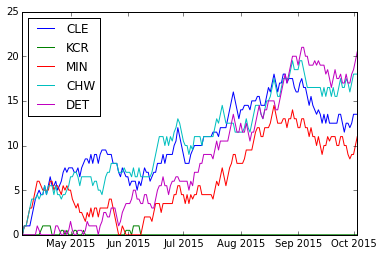

In [50]:
cle = dfALCentral[dfALCentral.Tm == 'CLE']
kcr = dfALCentral[dfALCentral.Tm == 'KCR']
minn = dfALCentral[dfALCentral.Tm == 'MIN']
chw = dfALCentral[dfALCentral.Tm == 'CHW']
det = dfALCentral[dfALCentral.Tm == 'DET']
plt.figure()
plt.plot(cle.index.values, cle['GB'], label='CLE')
plt.plot(kcr.index.values, kcr['GB'], label='KCR')
plt.plot(minn.index.values, minn['GB'], label='MIN')
plt.plot(chw.index.values, chw['GB'], label='CHW')
plt.plot(det.index.values, det['GB'], label='DET')
plt.legend(loc='best')
plt.show()

### What's wrong here?
* Y-scale is inverted.
* Too small and crowded.
* Colors are wrong.
* Only covers one division - there are five others.

### How to fix?
* Invert the Y values prior to plotting.
* Set the figure size manually - don't rely on defaults.
* Make the plot dynamic so you can switch divisions on the fly.

#### 1. Create some metadata for a dropdown list and colormap.

In [51]:
dropList = OrderedDict(zip(dfMaster.index.levels[0].values, dfMaster.index.levels[0].values))

mlb_colors = {'HOU': '#072854', 'CIN': '#C6011F', 'NYM': '#FB4F14', 'PHI': '#BA0C2F',
              'LAD': '#083C6B', 'LAA': '#B71234', 'COL': '#333366', 'TOR': '#003DA5', 
              'WSN': '#BA122B', 'BAL': '#ED4C09', 'STL': '#C41E3A', 'SDP': '#002147', 
              'ARI': '#A71930', 'MIL': '#92754C', 'MIN': '#C6011F', 'MIA': '#F9423A', 
              'BOS': '#C60C30', 'OAK': '#003831', 'PIT': '#FDB829', 'CHC': '#003279', 
              'CHW': '#000000', 'SFG': '#F2552C', 'DET': '#001742', 'TBR': '#00285D', 
              'KCR': '#15317E', 'ATL': '#B71234', 'TEX': '#BD1021', 'SEA': '#005C5C', 
              'CLE': '#003366', 'NYY': '#1C2841'}

#### 2. Embed a dropdown in the notebook that handles the plotting for us.
* Pass the division into a plotting function.
* Plot each series with a __for__ loop.
* Since it's a timeline, extend the X-axis - make it a rectangle.
* Remove axes

In [53]:
def to_unix_time(dteTm):
    epoch =  dt.utcfromtimestamp(0)
    tmp = dt.utcfromtimestamp(dteTm.tolist()/1e9)
    return (tmp - epoch).total_seconds() * 1000

In [67]:
#def plot_division_plotly(division):
data = []
tmpMaster = dfMaster.ix['AL Central', ['Tm', 'GB']]
tmpMaster.head()
for team in enumerate(tmpMaster.Tm.value_counts().index.values):
    tmp = tmpMaster[tmpMaster.Tm == team[1]]
    tmp.replace({'--': 0}, inplace=True)
    tmp['GB'] = tmp['GB'].astype(float)
    tmp.loc[:,'GB'] = tmp.loc[:,'GB'] * -1
    data.append(go.Scatter(x=tmp.index.values,
                           y=tmp['GB'],
                           line=go.Line(),
                           mode='lines',
                           name='{0}'.format(team[1]) ) )

layout = go.Layout(
    title='AL Central Standings',
    
    xaxis = dict(
        showgrid=False,
        range = [to_unix_time(x) for x in tmpMaster.index.values]
    )
)

fig = go.Figure(data = data)

py.iplot(fig, filename='python-datetime-custom-ranges')

#divWplotly = ipywidgets.Dropdown(options=dropList)
#initplotly = divW.value
#jPlotly = ipywidgets.interactive(plot_division_plotly, division=divWplotly)
#display(jPlotly)

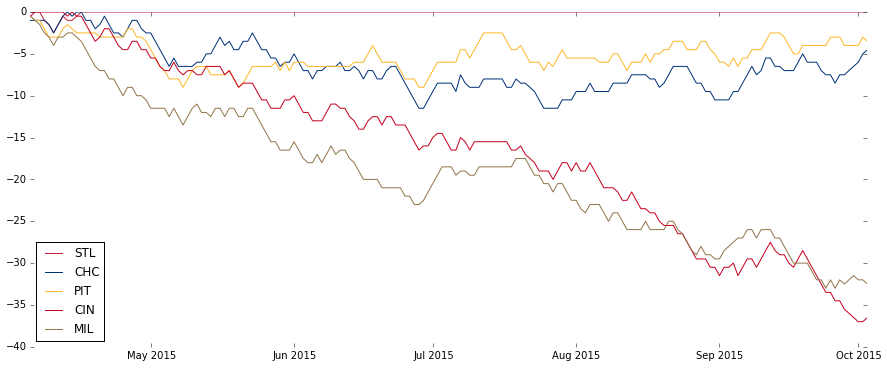

None

In [58]:
def plot_division(division):
    tmpMaster = dfMaster.ix[division, ['Tm', 'GB']]

    plt.figure(figsize=(15,6))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)  
    for team in enumerate(tmpMaster.Tm.value_counts().index.values):
        tmp = tmpMaster[tmpMaster.Tm == team[1]]
        tmp.replace({'--': 0}, inplace=True)
        tmp['GB'] = tmp['GB'].astype(float)
        tmp.loc[:,'GB'] = tmp.loc[:,'GB'] * -1
        plt.plot(tmp.index.values, tmp['GB'], label=team[1], color=mlb_colors[team[1]])

    plt.legend(loc='best')
    plt.show()


divW = ipywidgets.Dropdown(options=dropList, )
init = divW.value
j = ipywidgets.interactive(plot_division, division=divW)
display(j)